import libraries

In [1]:
import pandas as pd
import geopandas as gpd
import pygeohash as pgh
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data

In [2]:
points_geo = pd.read_csv('df_resolute_CLEANED_4IQR_4PREP_priceperm2IQR.csv',
                         parse_dates = ['ModifiedOn'])

points_geo['NAME_LATIN'] = points_geo['NAME_LATIN'].astype('category')
points_geo['PropertyTy'] = points_geo['PropertyTy'].astype('category')

# drop columns that wont be used
points_geo.drop(['Month','ModifiedOn'], axis=1, inplace=True)

In [3]:
points_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
NAME_LATIN      76000 non-null category
Area_sqm        76000 non-null int64
PropertyTy      76000 non-null category
Bedrooms        76000 non-null int64
Bathrooms       76000 non-null int64
Rooms           76000 non-null int64
Levels          76000 non-null int64
PriceEuro       76000 non-null int64
PricePerM2      76000 non-null float64
Year            76000 non-null int64
dist_coast      76000 non-null float64
dist_beach      76000 non-null float64
dist_city       76000 non-null float64
oiki_densi      76000 non-null float64
pop_densi       76000 non-null float64
construction    76000 non-null int64
dtypes: category(2), float64(6), int64(8)
memory usage: 8.4 MB


### data transformation

age

In [4]:
# age of add when sold
points_geo['age'] = points_geo['Year']-points_geo['construction']
points_geo.drop(['Year','construction'], axis=1, inplace=True)

In [5]:
# we could add the age into categories
# bins=[ 0 , 1969, 1979, 1989, 1999, 2009, 2019, 2029]
# choices =["60s", "70s", "80s", "90s", "00s", "10s", "20s"]
# points_geo['age_range']=pd.cut(points_geo['age'],bins=bins,labels=choices)

distances to binary

In [6]:
# convert the distances to kilometres
points_geo['dist_coast'] = points_geo['dist_coast']*100
points_geo['dist_beach'] = points_geo['dist_beach']*100
points_geo['dist_city'] = points_geo['dist_city']*100

In [7]:
dist_close_threshold = 30

points_geo['near_coast'] = points_geo['dist_coast'].apply(lambda x: 1 if x > dist_close_threshold else 0)
points_geo['near_beach'] = points_geo['dist_beach'].apply(lambda x: 1 if x > dist_close_threshold else 0)
points_geo['near_city'] = points_geo['dist_city'].apply(lambda x: 1 if x > dist_close_threshold else 0)

points_geo.drop(['dist_coast','dist_beach', 'dist_city'], axis=1, inplace=True)

property types to parent categories

In [8]:
# create parent categories for the property types

In [9]:
replace_dict = {'residential':['Apartment', 'Detached House', 'Maisonette', 'Studio Flat', 'Villa',
               'Garage', 'Other Residential Properties Types', 'Apartment complex',
              'Bungalow', 'Loft', 'Detachable', 'Prefabricated'],
                'land':['Land Plot', 'Parcel', 'Other Land Types'],
                'business':['Business', 'Office', 'Other Commercial Properties Types', 'Hotel'],
                'other':['Building', 'Business building', 'Other Properties', 'Warehouse',
            'Industrial space', 'Craft space', 'Hall', 'Air', 'Island', 'Farm']}

In [10]:
points_geo['property'] = None
points_geo['property'] = points_geo['PropertyTy']\
                .apply(lambda x: [key for key, value in replace_dict.items() if x in value][0] )
points_geo.drop(['PropertyTy'], axis=1, inplace=True)

NAME_LATIN to centroid lat, lng

In [11]:
name_latin_centroid = gpd.read_file('../data/oriaprokapodistriakwnota/oria_prokapodistriakwn_ota/oria_prokapodistriakwn_ota_WGS84_centroid_coords.shp')
name_latin_centroid.drop(['id', 'geometry'], axis=1, inplace=True)

In [12]:
points_geo = pd.merge(points_geo, name_latin_centroid, on='NAME_LATIN')

In [13]:
#points_geo.drop(['NAME_LATIN'], axis=1, inplace=True)
points_geo.rename(columns={'xcoord':'longitude', 'ycoord':'latitude'}, inplace=True)

discretize the centroid lat, lng

In [14]:
# https://www.movable-type.co.uk/scripts/geohash.html
# size=5 (4.9km x 4.9km)
points_geo['geohash'] = np.vectorize(lambda longitude, latitude: pgh.encode(latitude, longitude, precision=5))(
            points_geo['longitude'], 
            points_geo['latitude'])

In [15]:
points_geo['geohash_lat'] = points_geo['geohash'].apply(lambda x: pgh.decode(x)[0])
points_geo['geohash_lng'] = points_geo['geohash'].apply(lambda x: pgh.decode(x)[1])

In [16]:
points_geo.drop(['geohash'], axis=1, inplace=True) #'longitude', 'latitude'

encode categorical variables

In [17]:
n_points_geo = pd.concat([points_geo, pd.get_dummies(points_geo['property'],prefix='property')], axis=1)
n_points_geo.drop(['property'],axis=1, inplace=True)

In [18]:
n_points_geo.describe()

,Area_sqm,Bedrooms,Bathrooms,Rooms,Levels,PriceEuro,PricePerM2,oiki_densi,pop_densi,age,...,near_beach,near_city,longitude,latitude,geohash_lat,geohash_lng,property_business,property_land,property_other,property_residential
count,76000.000000,76000.000000,76000.000000,76000.0,76000.0,7.600000e+04,76000.000000,76000.000000,76000.000000,76000.000000,...,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,394.291974,1.081592,0.553605,0.0,0.0,1.703125e+05,931.539874,0.143201,21693.920349,41.414934,...,0.085539,0.137961,23.436116,38.656307,38.655663,23.442988,0.021842,0.452618,0.019500,0.506039
std,499.181907,1.293764,0.674069,0.0,0.0,1.714527e+05,772.606003,0.150119,19792.168699,24.049459,...,0.279685,0.344861,1.082967,1.389079,1.390381,1.084706,0.146169,0.497753,0.138275,0.499967
min,4.000000,0.000000,0.000000,0.0,0.0,9.990000e+02,0.400000,0.006560,120.000000,-8.000000,...,0.000000,0.000000,19.849540,34.959410,35.000000,19.800000,0.000000,0.000000,0.000000,0.000000
25%,82.000000,0.000000,0.000000,0.0,0.0,6.000000e+04,260.000000,0.054690,7232.000000,15.000000,...,0.000000,0.000000,22.951890,37.946210,37.900000,23.000000,0.000000,0.000000,0.000000,0.000000
50%,160.000000,0.000000,0.000000,0.0,0.0,1.100000e+05,781.000000,0.101780,13552.000000,57.000000,...,0.000000,0.000000,23.699960,38.056820,38.100000,23.700000,0.000000,0.000000,0.000000,1.000000
75%,500.000000,2.000000,1.000000,0.0,0.0,2.200000e+05,1389.000000,0.187470,30279.000000,61.000000,...,0.000000,0.000000,23.844610,40.057190,40.100000,23.800000,0.000000,1.000000,0.000000,1.000000
max,2622.000000,10.000000,5.000000,0.0,0.0,1.210000e+06,3243.000000,1.328700,87659.500000,719.000000,...,1.000000,1.000000,29.581550,41.641950,41.600000,29.600000,1.000000,1.000000,1.000000,1.000000


In [19]:
n_points_geo.dtypes

NAME_LATIN               object
Area_sqm                  int64
Bedrooms                  int64
Bathrooms                 int64
Rooms                     int64
Levels                    int64
PriceEuro                 int64
PricePerM2              float64
oiki_densi              float64
pop_densi               float64
age                       int64
near_coast                int64
near_beach                int64
near_city                 int64
longitude               float64
latitude                float64
geohash_lat             float64
geohash_lng             float64
property_business         uint8
property_land             uint8
property_other            uint8
property_residential      uint8
dtype: object

### save to csv 

In [20]:
# n_points_geo.to_csv('df_resolute_CLEANED_4IQR_4PREP_priceperm2IQR_prep.csv', index=False)

### corr analysis 

In [21]:
less_points_geo = n_points_geo.drop(['PriceEuro','NAME_LATIN', 'longitude', 'latitude'], axis=1)

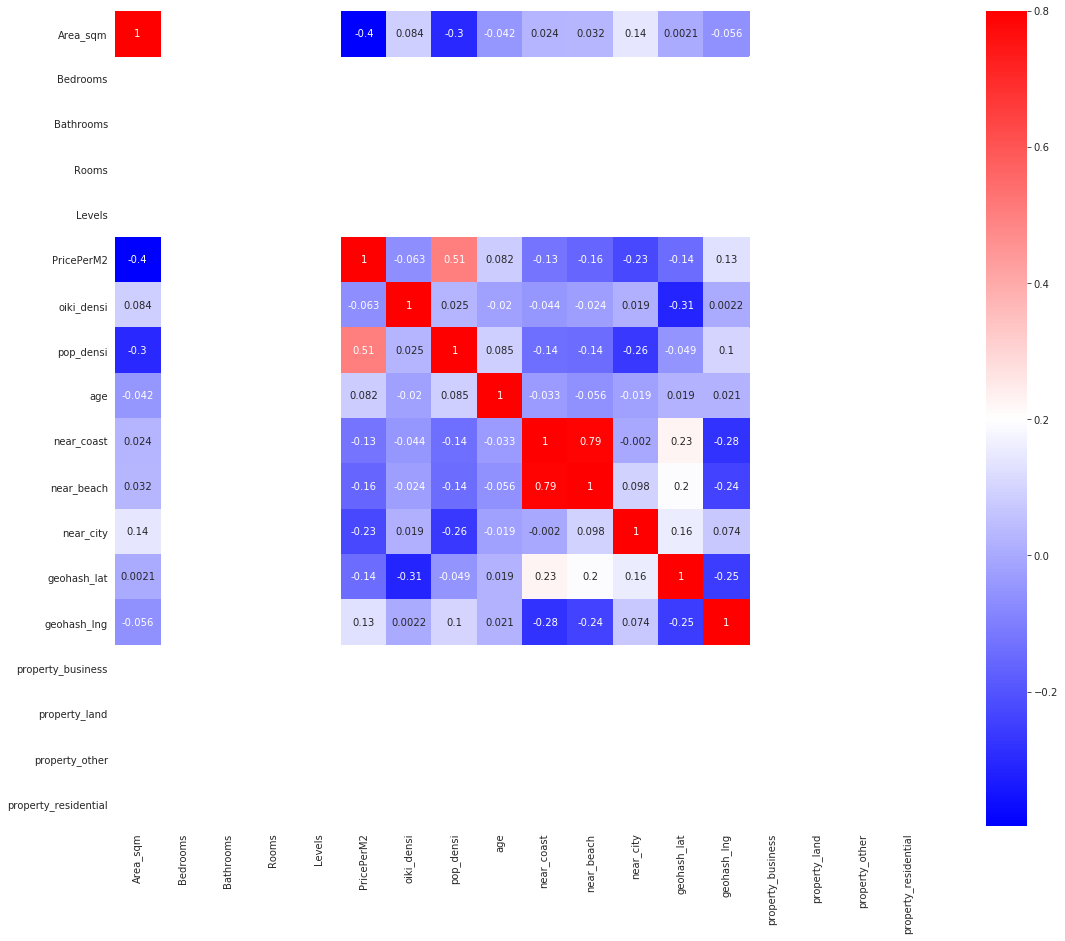

In [22]:
# Correlation Matrix Heatmap
corrmat = less_points_geo[less_points_geo.property_land==1].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True, cmap='bwr')

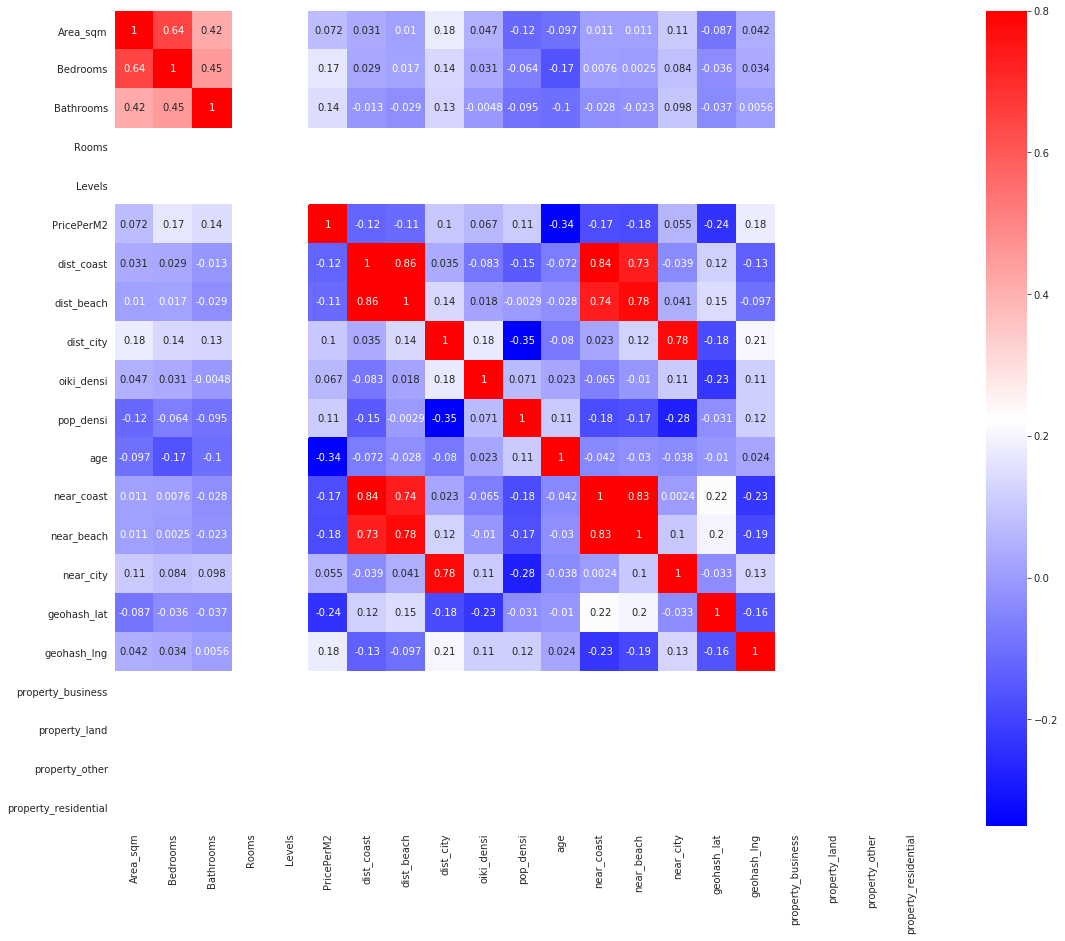

In [24]:
# Correlation Matrix Heatmap
corrmat = less_points_geo[less_points_geo.property_residential==1].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True, cmap='bwr')

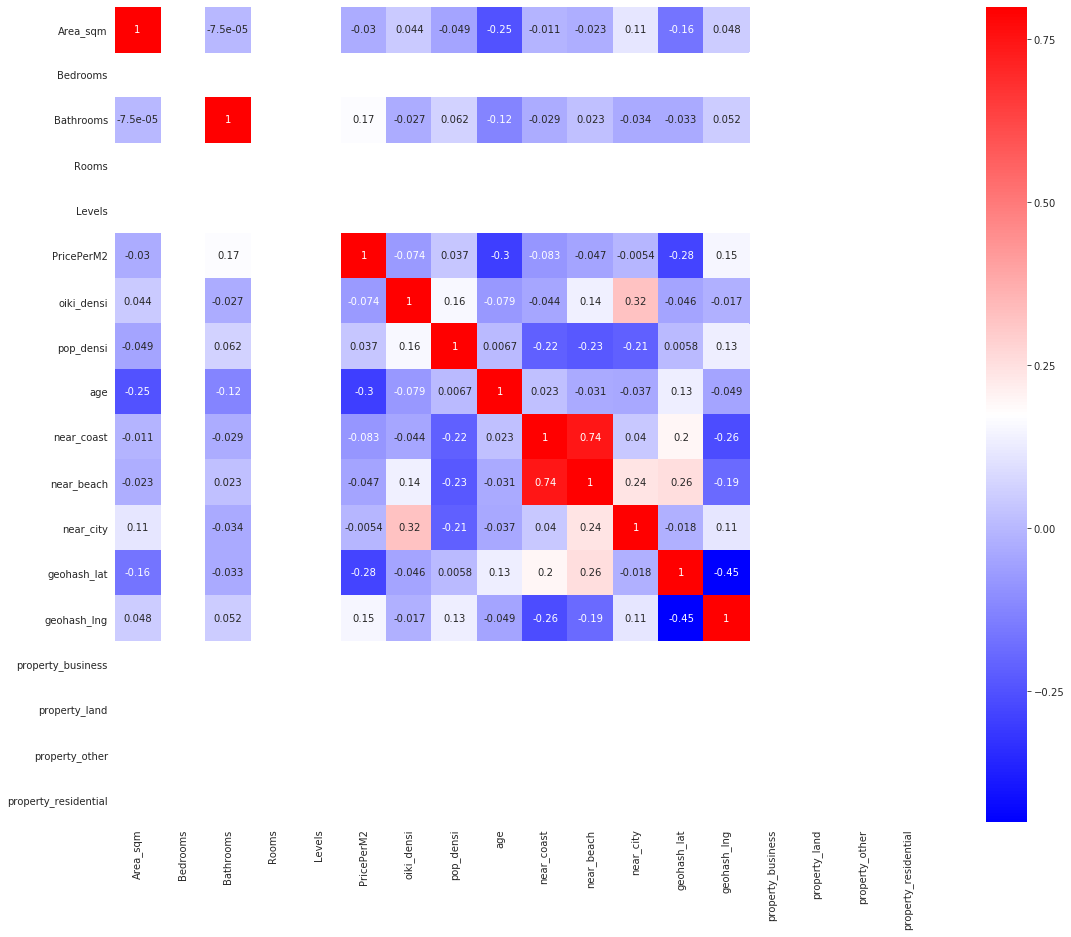

In [111]:
# Correlation Matrix Heatmap
corrmat = less_points_geo[less_points_geo.property_business==1].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True, cmap='bwr')